In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import geopandas as gpd
from shapely.wkt import loads
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

PROCESSED_DATA_DIR = "../../data/processed data"
MERGED_DATA_DIR = "../../data/merged data"

acs = pd.read_csv("../../data/processed data/census_tract_clusters.csv")

gdf = pd.read_csv("../../data/raw data/chicago_census_blocks_boundaries.csv")

if "the_geom" in gdf.columns:
    gdf["geometry"] = gdf["the_geom"].apply(loads)
else:
    raise ValueError("The boundary file does not contain a valid geometry column!")

gdf = gpd.GeoDataFrame(gdf, geometry="geometry", crs="EPSG:4326")

In [10]:
gdf = gdf.to_crs(epsg=3857)

gdf["land_area_m2"] = gdf.geometry.area
gdf["land_area_km2"] = gdf["land_area_m2"] / 1e6

gdf.to_csv("../../data/processed data/chicago_census_blocks_with_area.csv", index=False)

In [11]:
tnp = pd.read_csv(os.path.join(MERGED_DATA_DIR, "2020", "merged_tnp_data.csv"))

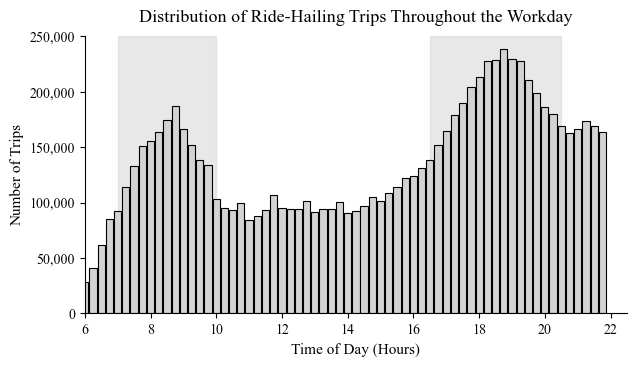

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# AEJ 图表风格设置
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})

# 数据准备（15分钟粒度）
trip_counts = tnp["trip_start_time_of_day_f"].round(2).value_counts().sort_index()
x = trip_counts.index.values.astype(float)
y = trip_counts.values
bar_width = 0.22  # 每 15 分钟宽度

# 创建图表
fig, ax = plt.subplots(figsize=(6.5, 3.8))

# ✅ 添加 Rush Hours 阴影区域
# 上午高峰：7:00–9:30；下午高峰：16:30–21:00
rush_hours = [(7, 10), (16.5, 20.5)]
for start, end in rush_hours:
    ax.axvspan(start, end, color="lightgrey", alpha=0.5, zorder=0)

# ✅ 绘制主柱图
ax.bar(x, y, width=bar_width, color="lightgray", edgecolor="black", linewidth=0.8, zorder=1)

# 设置标签
ax.set_title("Distribution of Ride-Hailing Trips Throughout the Workday", pad=10)
ax.set_xlabel("Time of Day (Hours)")
ax.set_ylabel("Number of Trips")

# x 轴刻度与范围
ax.set_xlim(6, 22.5)
ax.set_xticks(np.arange(6, 23, 2))

# y 轴为千位逗号
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# 清除边框
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

# 可选保存
plt.savefig("../../output/data_summarize/trip_rush_hours_distribution.pdf", bbox_inches="tight", dpi=300)

plt.show()

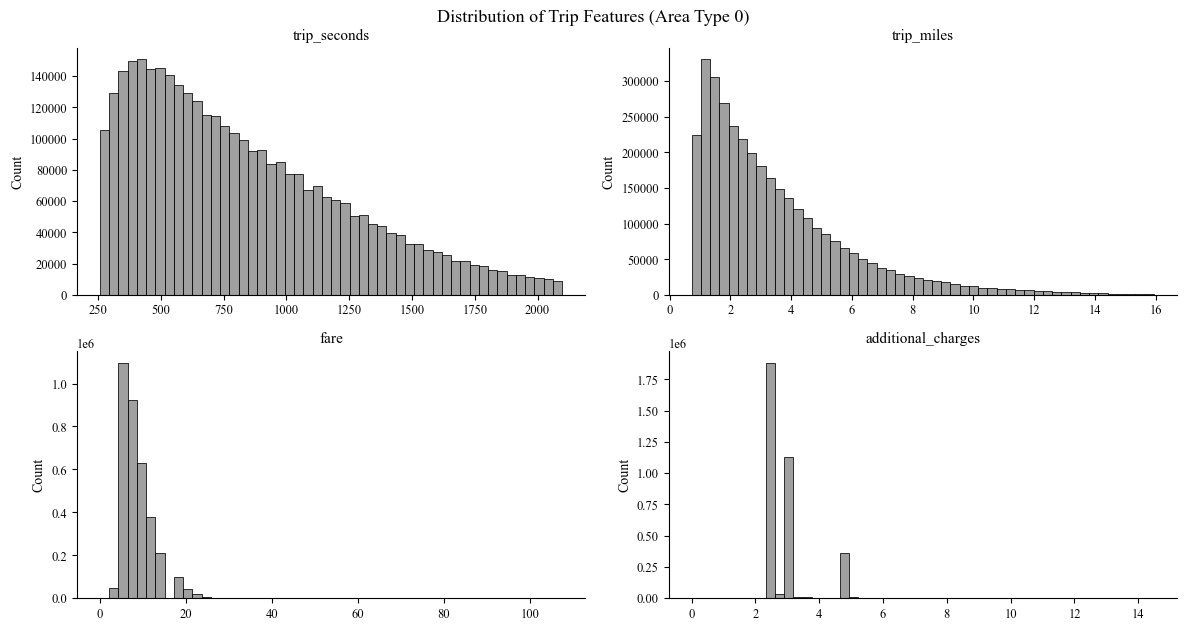

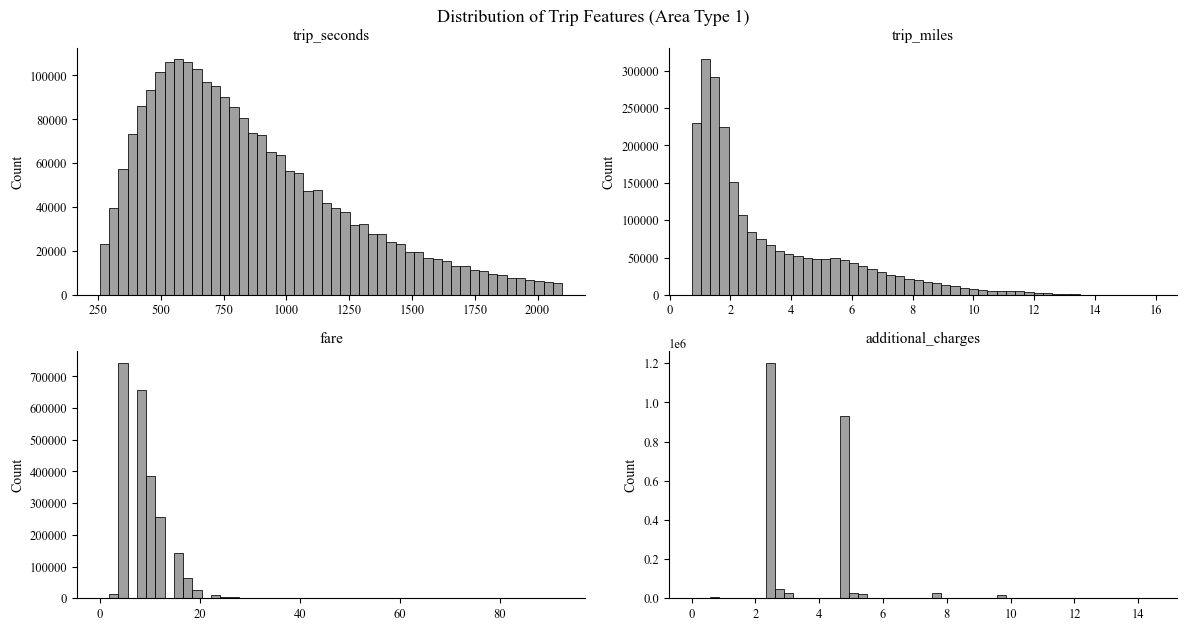

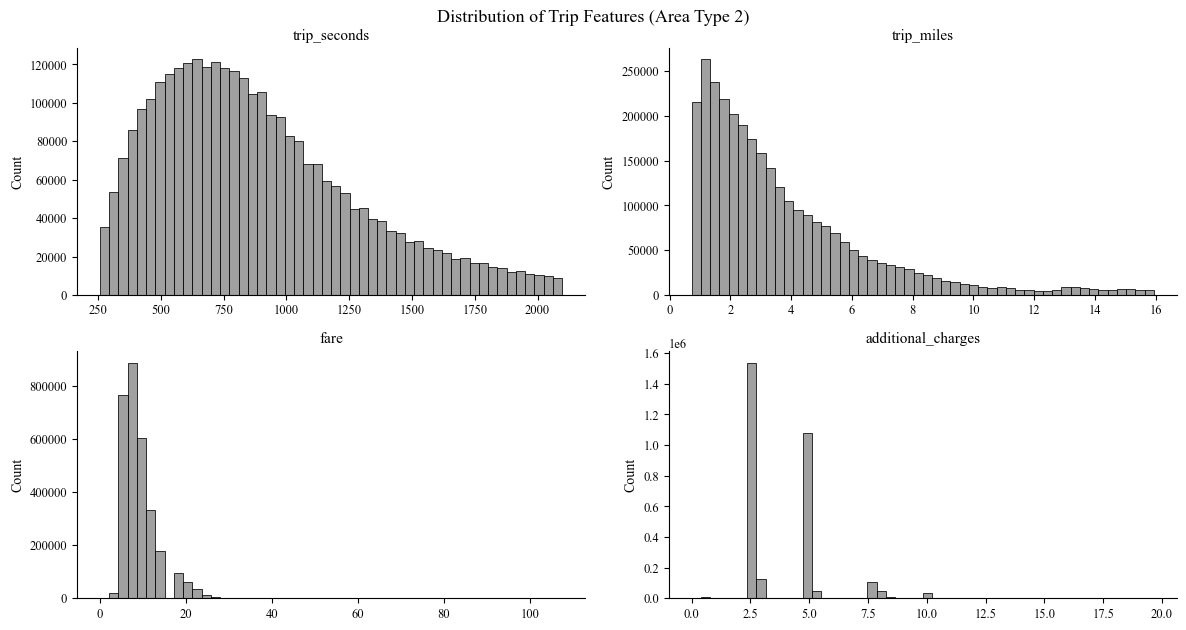

In [13]:
# 设置 AEJ 风格
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 11,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

# 核心变量
trip_features = [
    "trip_seconds", "trip_miles",
    "fare", "additional_charges"
]

n_cols = 2
n_rows = math.ceil(len(trip_features) / n_cols)

# 分组画图
for area in [0, 1, 2]:
    g_tnp = tnp[tnp["area_type"] == area]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.2 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(trip_features):
        sns.histplot(
            g_tnp[feature],
            bins=50,
            color="gray",
            edgecolor="black",
            ax=axes[i]
        )
        axes[i].set_title(feature, fontweight="normal")
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("")
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].grid(False)

    # 删除多余子图框
    for j in range(len(trip_features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    fig.suptitle(f"Distribution of Trip Features (Area Type {area})", fontsize=13)
    plt.subplots_adjust(top=0.92)

    # 可选：保存图像为 PDF
    plt.savefig(f"../../output/data_summarize/appendix_trip_distributions_area{area}_2020.pdf", dpi=300, bbox_inches="tight")

    plt.show()

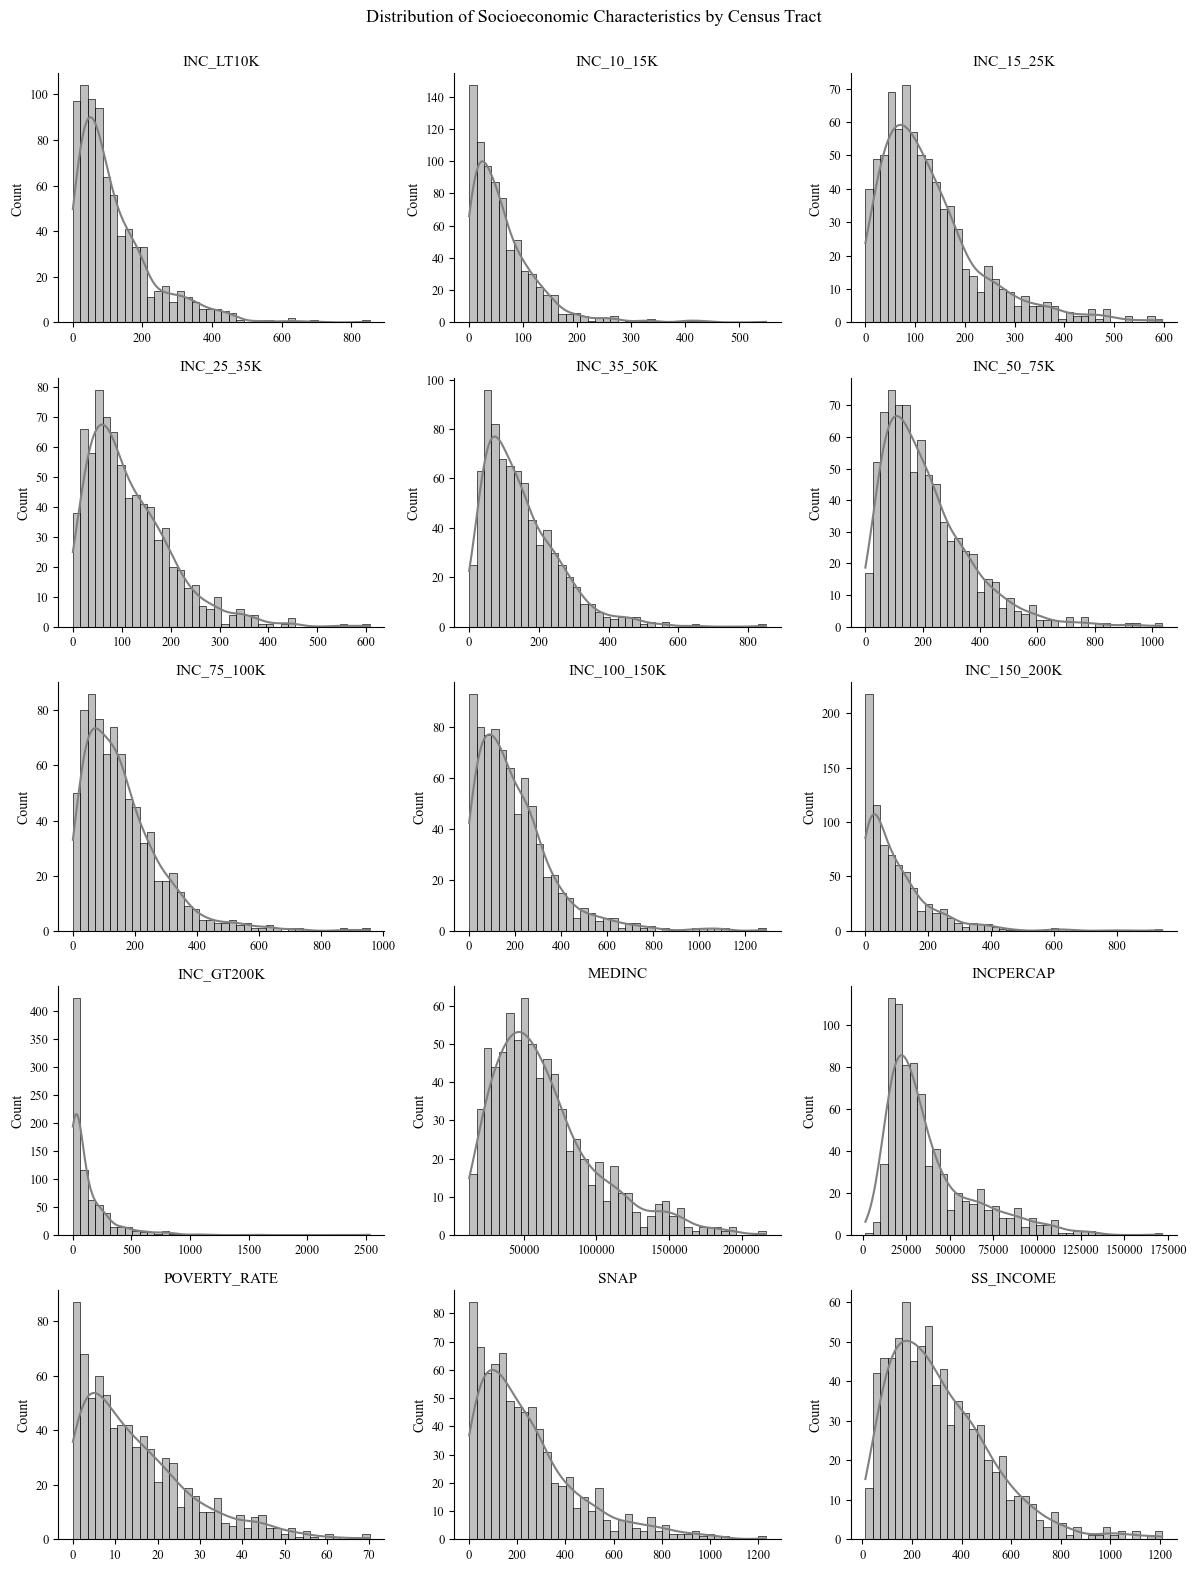

In [14]:
VARIABLES = {
    "INC_LT10K": "DP03_0052E",       # Income < $10k
    "INC_10_15K": "DP03_0053E",
    "INC_15_25K": "DP03_0054E",
    "INC_25_35K": "DP03_0055E",
    "INC_35_50K": "DP03_0056E",
    "INC_50_75K": "DP03_0057E",
    "INC_75_100K": "DP03_0058E",
    "INC_100_150K": "DP03_0059E",
    "INC_150_200K": "DP03_0060E",
    "INC_GT200K": "DP03_0061E",
    "MEDINC": "DP03_0062E",          # Median Household Income
    "INCPERCAP": "DP03_0088E",       # Per Capita Income
    "POVERTY_RATE": "DP03_0119PE",   # % Below Poverty Line
    "SNAP": "DP03_0074E",            # Households with Food Stamps/SNAP
    "SS_INCOME": "DP03_0066E",       # Households with Social Security Income
}

socioeconomic_features = VARIABLES.keys()
tnp_by_community = tnp.groupby("pickup_census_tract").agg(lambda x: x.iloc[0] if x.dtype == object else x.mean()).reset_index()

# 字体设置为 Times New Roman，风格向 AEJ 靠拢
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 11,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

n_cols = 3
n_rows = math.ceil(len(socioeconomic_features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.2 * n_rows))

axes = axes.flatten()  # 统一处理 axes 索引
for i, feature in enumerate(socioeconomic_features):
    sns.histplot(
        tnp_by_community[feature],
        bins=40,
        kde=True,
        color="gray",
        edgecolor="black",
        ax=axes[i]
    )
    axes[i].set_title(feature, fontweight="normal")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("")
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(False)

# 移除多余子图框架
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.94)
fig.suptitle("Distribution of Socioeconomic Characteristics by Census Tract", fontsize=13)

plt.savefig(f"../../output/data_summarize/appendix_distribution_of_socioeconomic_characteristics.pdf", dpi=300, bbox_inches="tight")

plt.show()


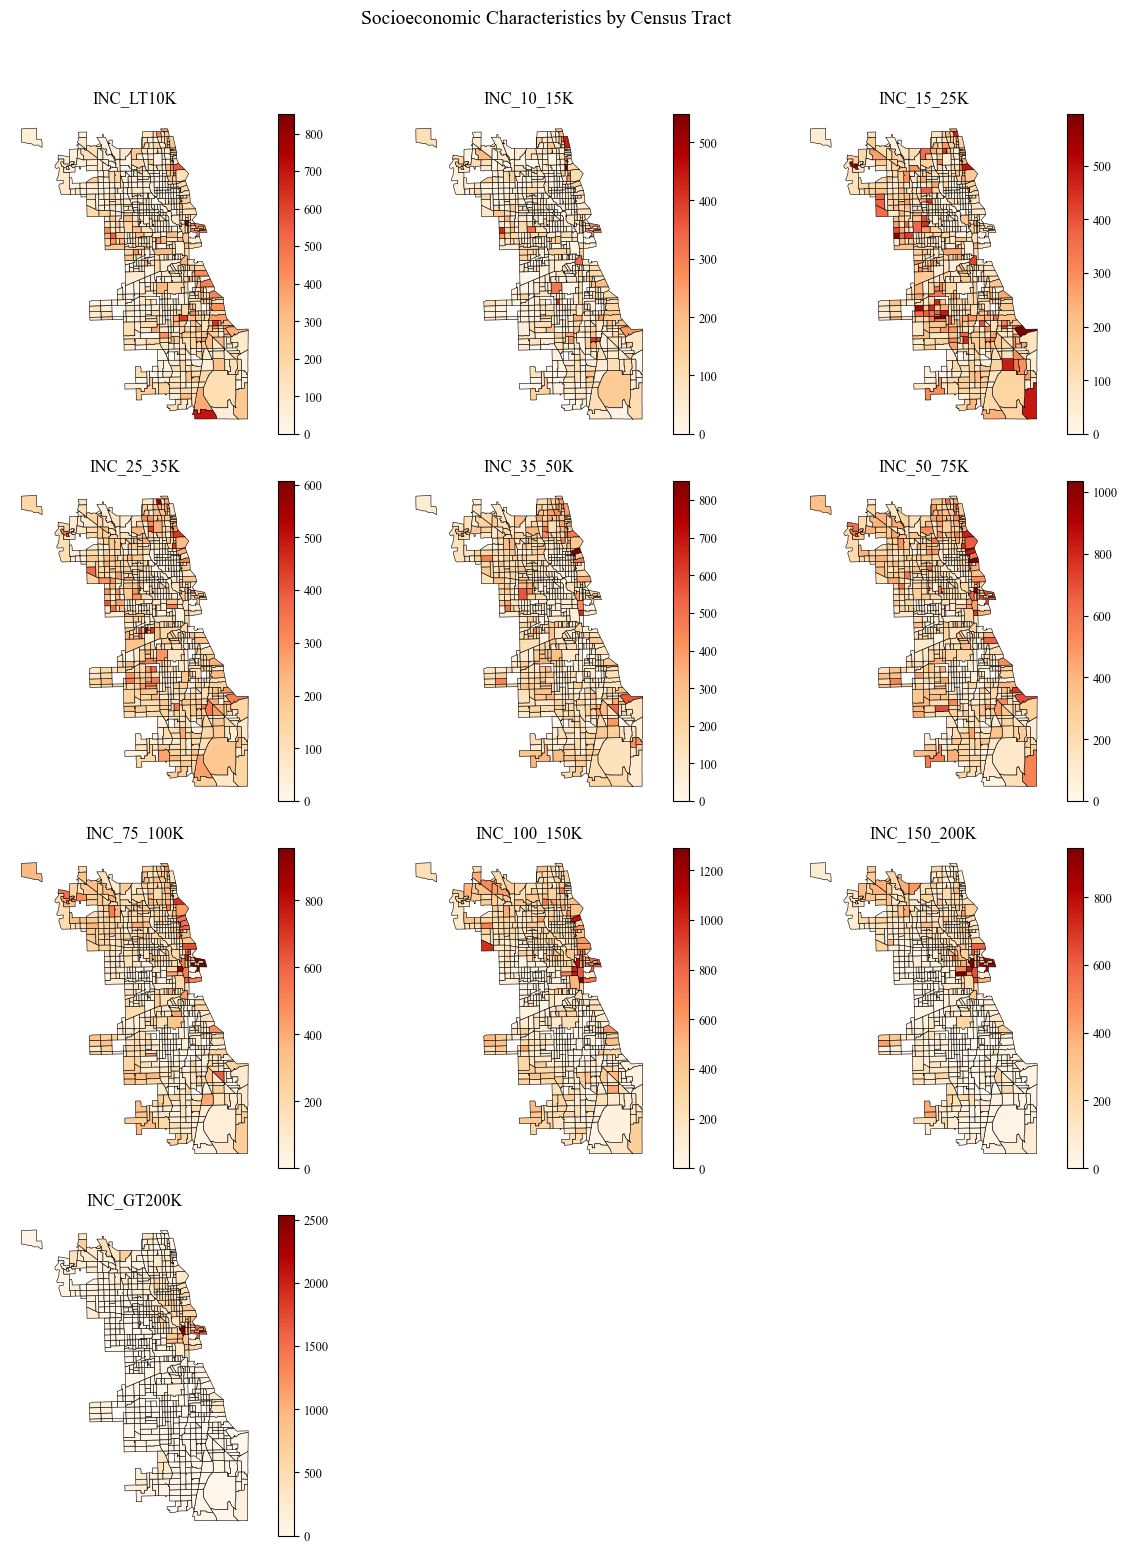

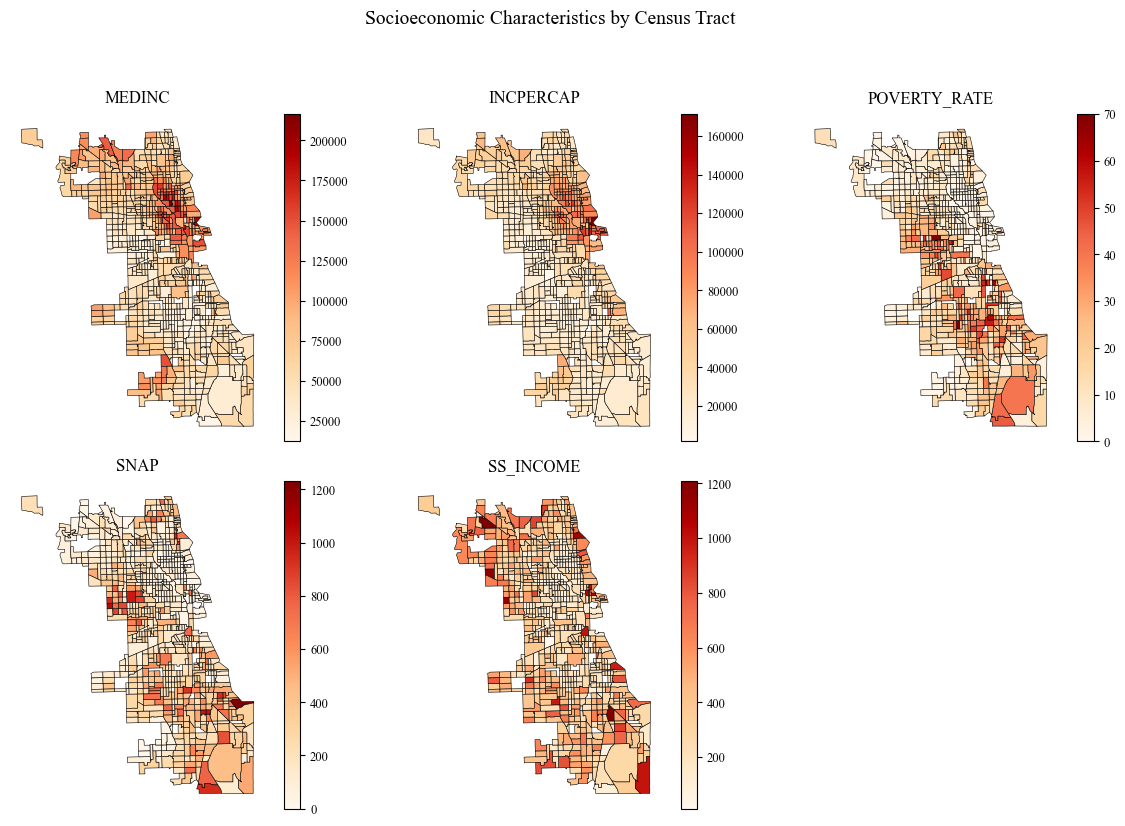

In [15]:
# AEJ 风格设定
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

# 准备数据
acs["GEOID"] = acs["GEOID"].astype(str)
gdf["GEOID10"] = gdf["GEOID10"].astype(str)
acs_gdf = gdf.merge(acs, left_on="GEOID10", right_on="GEOID", how="left")

VARIABLES = {
    "INC_LT10K": "DP03_0052E",
    "INC_10_15K": "DP03_0053E",
    "INC_15_25K": "DP03_0054E",
    "INC_25_35K": "DP03_0055E",
    "INC_35_50K": "DP03_0056E",
    "INC_50_75K": "DP03_0057E",
    "INC_75_100K": "DP03_0058E",
    "INC_100_150K": "DP03_0059E",
    "INC_150_200K": "DP03_0060E",
    "INC_GT200K": "DP03_0061E",
    "MEDINC": "DP03_0062E",          
    "INCPERCAP": "DP03_0088E",       
    "POVERTY_RATE": "DP03_0119PE",   
    "SNAP": "DP03_0074E",            
    "SS_INCOME": "DP03_0066E",       
}

features = list(VARIABLES.keys())
features_per_page = 10  # 每页显示几个图
n_cols = 3
n_rows = math.ceil(features_per_page / n_cols)

# 分批绘制，每页 features_per_page 张
for i in range(0, len(features), features_per_page):
    batch = features[i:i + features_per_page]
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.8 * n_rows))
    axes = axes.flatten()

    for j, feature in enumerate(batch):
        acs_gdf[feature] = pd.to_numeric(acs_gdf[feature], errors="coerce")

        acs_gdf.plot(
            column=feature,
            cmap="OrRd",
            linewidth=0.4,
            edgecolor="black",
            legend=True,
            ax=axes[j]
        )
        axes[j].set_title(f"{feature}", pad=8)
        axes[j].set_axis_off()

        leg = axes[j].get_legend()
        if leg:
            leg.set_title("")

    # 清除多余空格子
    for k in range(len(batch), len(axes)):
        fig.delaxes(axes[k])

    fig.suptitle("Socioeconomic Characteristics by Census Tract", fontsize=14, y=1.02)
    plt.tight_layout()
    
    # 可选保存：
    plt.savefig(f"../../output/data_summarize/acs_map_page_{i // features_per_page + 1}.pdf", bbox_inches="tight", dpi=300)

    plt.show()

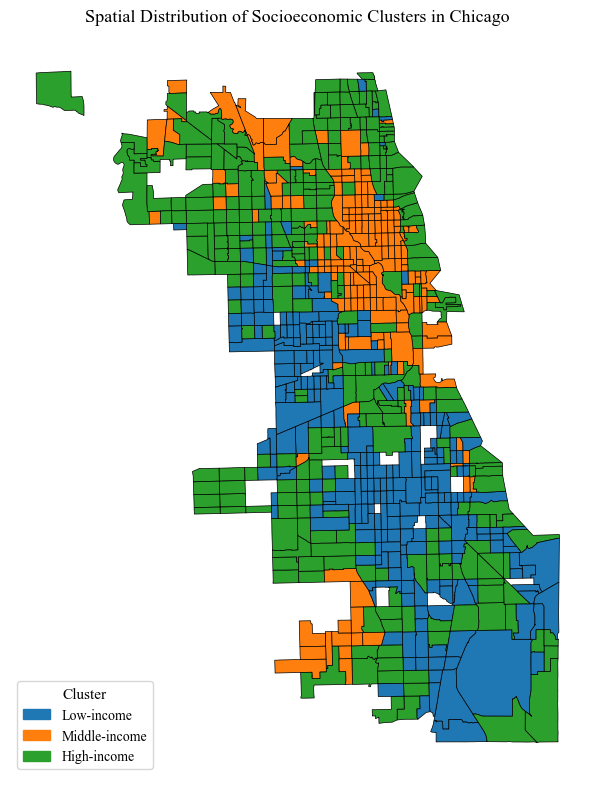

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import seaborn as sns

# AEJ 风格设定
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

# 确保 ID 格式一致
acs["GEOID"] = acs["GEOID"].astype(str)
gdf["GEOID10"] = gdf["GEOID10"].astype(str)

# 合并 shapefile 和聚类信息
acs_gdf = gdf.merge(acs, left_on="GEOID10", right_on="GEOID", how="left")

# 转换为整数类别（Cluster）
acs_gdf["Cluster"] = pd.to_numeric(acs_gdf["Cluster"], errors="coerce")
acs_gdf = acs_gdf.dropna(subset=["Cluster"]).copy()
acs_gdf["Cluster"] = acs_gdf["Cluster"].astype(int)

# ✅ 明确聚类顺序和标签
cluster_order = [0, 1, 2]  # 顺序要手动确认是否符合你模型结果
cluster_labels = {
    0: "Low-income",
    1: "Middle-income",
    2: "High-income",
}

# ✅ 明确颜色对应关系（与你 legend 一致）
cluster_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # 蓝、橙、绿
cmap = ListedColormap(cluster_colors)

# ✅ 绘图
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
acs_gdf.plot(
    column="Cluster",
    cmap=cmap,
    linewidth=0.5,
    edgecolor="black",
    categorical=True,
    legend=False,
    ax=ax
)

# ✅ 自定义 legend
legend_handles = [
    mpatches.Patch(color=cluster_colors[i], label=cluster_labels[cluster_order[i]])
    for i in range(len(cluster_order))
]

ax.legend(
    handles=legend_handles,
    title="Cluster",
    loc="lower left",
    frameon=True
)

ax.set_title("Spatial Distribution of Socioeconomic Clusters in Chicago", pad=12)
ax.set_axis_off()
plt.tight_layout()

# ✅ 可选保存
plt.savefig("../../output/data_summarize/socioeconomic_clusters_map.pdf", bbox_inches="tight", dpi=300)
plt.show()